In [2]:
# Klasifikavimas c4.5 algoritmu (medžiai)

In [165]:
from sqlalchemy import create_engine

In [166]:
# Prisijungimo parametrai
server = 'mssql-117961-0.cloudclusters.net,19996'  # Pavyzdžiui, 'localhost'
database = 'finance'  # Duomenų bazės pavadinimas
username = 'user1'  # Jūsų vartotojo vardas
password = 'User_111'  # Jūsų slaptažodis

In [167]:
connection_string = f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver=SQL+Server'
engine = create_engine(connection_string)

In [168]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [240]:
# Nurodome SQL užklausą
sql_query = 'SELECT * FROM dimCustomer'  # Jūsų lentelės pavadinimas

# Naudojame PANDAS, kad nuskaitytume duomenis
# df = pd.read_sql(sql_query, engine)
# Nuskaitome visus pardavimus
sql_query='select * from FactInternetSales'
# df_pardavimai = pd.read_sql(sql_query, engine)



sql_query='SELECT * FROM FactInternetSales INNER JOIN dimCustomer ON FactInternetSales.CustomerKey = dimCustomer.CustomerKey'

sql_query_optimize='select c.BirthDate, c.YearlyIncome, c.CustomerKey, c.CustomerAlternateKey, s.ProductKey from FactInternetSales as s left join DimCustomer as c on s.CustomerKey=c.CustomerKey'

df = pd.read_sql(sql_query_optimize, engine)


In [241]:
df.columns

Index(['BirthDate', 'YearlyIncome', 'CustomerKey', 'CustomerAlternateKey',
       'ProductKey'],
      dtype='object')

In [242]:
from datetime import datetime
df['BirthDate'] = pd.to_datetime(df['BirthDate'])
df['metai']=2023-df['BirthDate'].dt.year
df['metai']

0        71
1        53
2        71
3        80
4        50
         ..
60393    47
60394    47
60395    40
60396    40
60397    40
Name: metai, Length: 60398, dtype: int64

In [243]:
df_darbui =df[['CustomerAlternateKey','YearlyIncome','metai']]

In [244]:
purchase_counts = df.groupby('CustomerAlternateKey').size()
purchase_counts.name='a'

In [245]:
df_darbui=df_darbui.drop_duplicates('CustomerAlternateKey')

In [246]:
purchase_counts = df.groupby('CustomerAlternateKey').size()

In [247]:
purchase_counts.name='CustomerAlternateKey'

In [248]:
s_df = purchase_counts.reset_index(name='PurchaseCount')

In [249]:
merged_df = pd.merge(df_darbui, s_df, on='CustomerAlternateKey', how='left')

In [250]:
merged_df.describe()

,YearlyIncome,metai,PurchaseCount
count,18484.000000,18484.000000,18484.000000
mean,57305.777970,54.176531,3.267583
std,32285.841703,11.536142,2.620927
min,10000.000000,37.000000,1.000000
25%,30000.000000,45.000000,2.000000
50%,60000.000000,52.000000,3.000000
75%,70000.000000,62.000000,4.000000
max,170000.000000,107.000000,68.000000


In [251]:
merged_df['lojalumas_atsitiktinis']=np.random.randint(1, 4, merged_df.shape[0])
merged_df

,CustomerAlternateKey,YearlyIncome,metai,PurchaseCount,lojalumas_atsitiktinis
0,AW00021768,70000.0,71,2,2
1,AW00028389,20000.0,53,1,3
2,AW00025863,40000.0,71,5,2
3,AW00014501,80000.0,80,2,2
4,AW00011003,70000.0,50,9,3
...,...,...,...,...,...
18479,AW00021523,120000.0,60,2,2
18480,AW00021524,80000.0,65,4,2
18481,AW00024704,20000.0,40,1,2
18482,AW00026832,30000.0,46,3,3


In [252]:
conditions = [
    (merged_df['PurchaseCount'] <= 10),
    (merged_df['PurchaseCount'] > 10) & (merged_df['PurchaseCount'] <= 20),
    (merged_df['PurchaseCount'] > 20)
    ]
values = [3, 2, 1]
merged_df['lojalumas_pagal_pirkimus'] = np.select(conditions, values)
merged_df

,CustomerAlternateKey,YearlyIncome,metai,PurchaseCount,lojalumas_atsitiktinis,lojalumas_pagal_pirkimus
0,AW00021768,70000.0,71,2,2,3
1,AW00028389,20000.0,53,1,3,3
2,AW00025863,40000.0,71,5,2,3
3,AW00014501,80000.0,80,2,2,3
4,AW00011003,70000.0,50,9,3,3
...,...,...,...,...,...,...
18479,AW00021523,120000.0,60,2,2,3
18480,AW00021524,80000.0,65,4,2,3
18481,AW00024704,20000.0,40,1,2,3
18482,AW00026832,30000.0,46,3,3,3


In [253]:
# Duomenų paruošimas
X = merged_df[['YearlyIncome','metai','PurchaseCount']]
y = merged_df['lojalumas_atsitiktinis']

In [232]:
# Duomenų skaidymas į mokymo ir testavimo rinkinius
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [233]:
# Sprendimų medžio klasifikatoriaus sukūrimas ir apmokymas
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [234]:
# Modelio vertinimas
predictions = clf.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       0.33      0.43      0.38      1817
           2       0.34      0.31      0.33      1886
           3       0.33      0.26      0.29      1843

    accuracy                           0.33      5546
   macro avg       0.33      0.33      0.33      5546
weighted avg       0.33      0.33      0.33      5546



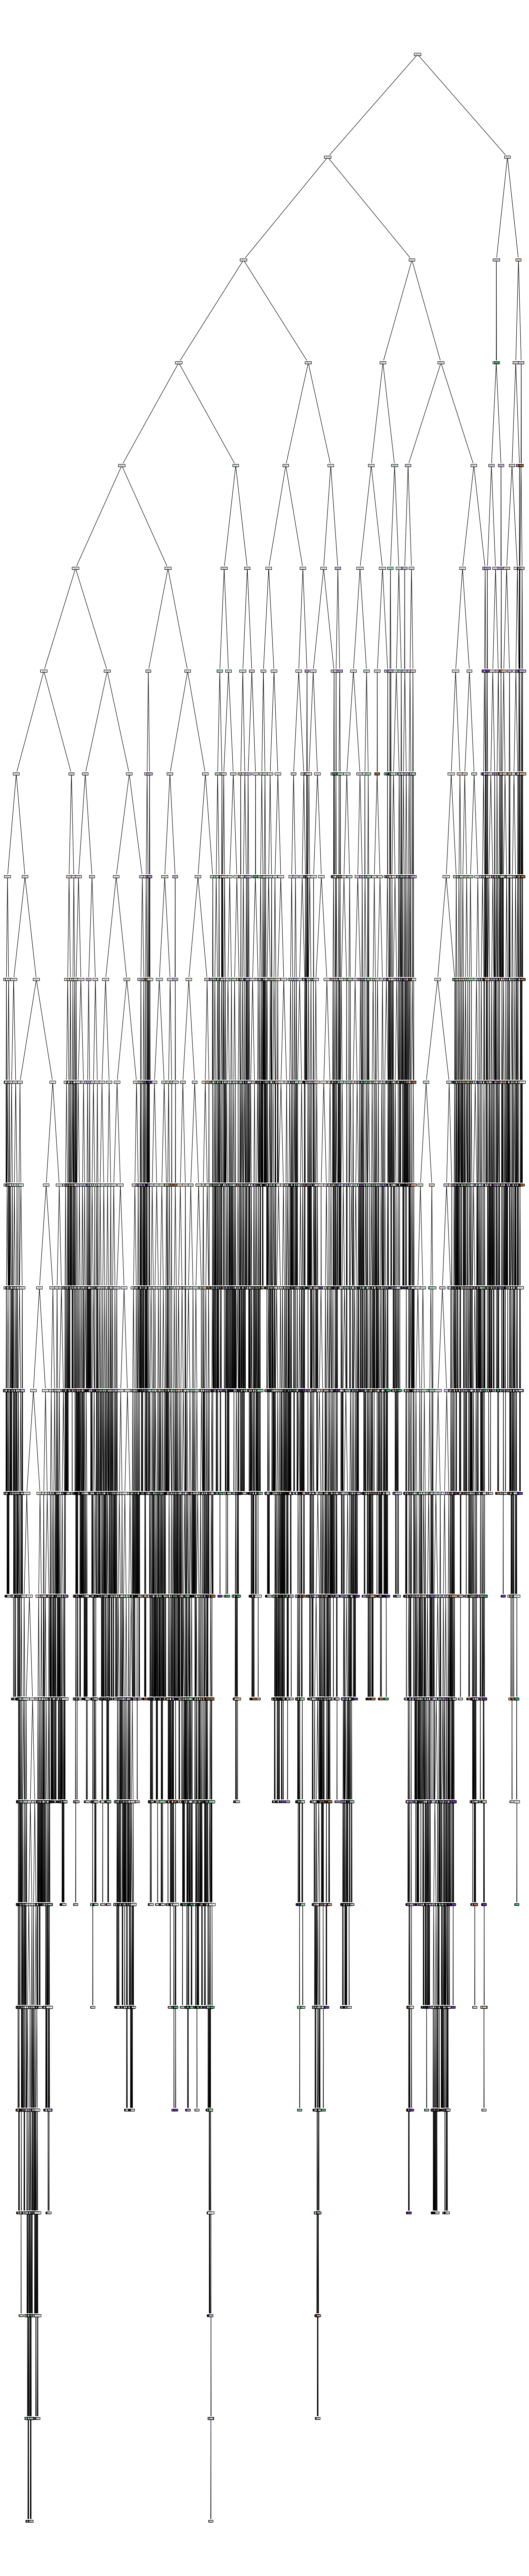

In [215]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.tree import plot_tree

# Sprendimų medžio vizualizacija
plt.figure(figsize=(20,100))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=['1', '2','3'], rounded=True, proportion=False, precision=2)
plt.show()


In [192]:
plt.savefig("output/medis.png")

<Figure size 640x480 with 0 Axes>

In [235]:
# Duomenų paruošimas
X = merged_df[['YearlyIncome','metai','PurchaseCount']]
y = merged_df['lojalumas_pagal_pirkimus']

In [236]:
# Duomenų skaidymas į mokymo ir testavimo rinkinius
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [237]:
# Sprendimų medžio klasifikatoriaus sukūrimas ir apmokymas
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [238]:
# Modelio vertinimas
predictions = clf.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        51
           3       1.00      1.00      1.00      5483

    accuracy                           1.00      5546
   macro avg       1.00      1.00      1.00      5546
weighted avg       1.00      1.00      1.00      5546



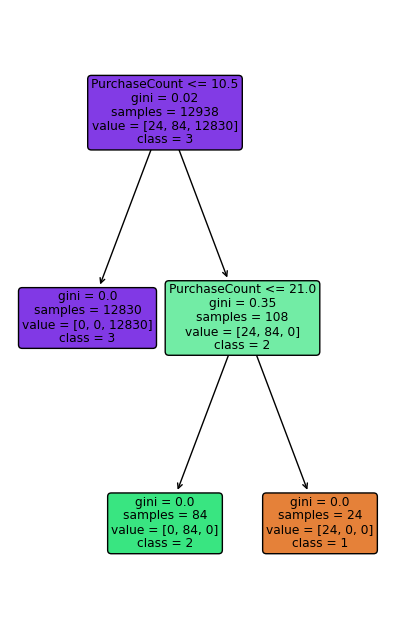

In [239]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.tree import plot_tree

# Sprendimų medžio vizualizacija
plt.figure(figsize=(5,8))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=['1', '2','3'], rounded=True, proportion=False, precision=2)
plt.show()
